In [147]:
%pylab inline
import os
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


In [148]:
factors = ['BHLHE40','CEBPB','CTCF','E2F4','EBF1','ELF1','ELK1','ETS1','FOS','IRF4','JunD','Max','MEF2A','MEF2C','Mxi1','NFIC','NFKB','NFYA','NFYB','Nrf1','NRSF','PAX5','PBX3','POU2F2','PU1','RFX5','RUNX3','SP1','SRF','STAT1','STAT3','TCF3','USF1','USF2','YY1','ZBTB33','ZEB1','Znf143']

controlGC = True
controlDNase = False


# Unified kmer list, taken from union of the kmer lists for the three models below
kmerlist = [item.strip() for item in open("kmers_unified.txt", "r").readlines()]

# Unified kmer list, ordered based on clustering in base case
ylabs = [item.strip() for item in open("kmers_ordered_all.txt", "r").readlines()]
xlabs = [item.strip() for item in open("tfs_ordered_all.txt", "r").readlines()]

if controlDNase:
    basepath = "/storage/pandaman/project/AgentBind-GM12878-analysis-DNase/"
    GCsuffix="DNase"
elif controlGC:
    basepath = "/storage/pandaman/project/AgentBind-GM12878-analysis/"
    GCsuffix=""
else:
    basepath = "/storage/pandaman/project/AgentBind-GM12878-analysis-archive-before-GC-balanced/"
    GCsuffix = "noGC"
    
fpath = os.path.join(basepath, "results/c/%s+GM12878/kmer_ranking.txt")
fpath_proximal = os.path.join(basepath, "results-proximal-distal/c/%s+GM12878/prox/kmer_ranking.txt")
fpath_distal = os.path.join(basepath, "results-proximal-distal/c/%s+GM12878/dist/kmer_ranking.txt")

pcols = ["pval_%s"%f for f in factors]
orcols = ["OR_%s"%f for f in factors]

def maxabs(x):
    return max(abs(x))

def compute_confidence_interval(fdata):
    """
    Formula from https://select-statistics.co.uk/calculators/confidence-interval-calculator-odds-ratio/
        a is the number of times both A and B are present,
        b is the number of times A is present, but B is absent,
        c is the number of times A is absent, but B is present, and
        d is the number of times both A and B are negative.
        
        Here, property A: "this kmer" (vs. other kmers)
        property B: high-score (vs. low-score)
        
    To calculate the confidence interval, we use the log odds ratio, log(or) = log(a*d/b*c),
    and calculate its standard error:
        se(log(or)) = √1/a + 1/b + 1/c +1/d

    The confidence interval, ci, is calculated as:
        ci = exp(log(or) ± Zα/2­*√1/a + 1/b + 1/c + 1/d),
    where Zα/2 is the critical value of the Normal distribution at α/2
    (e.g. for a confidence level of 95%, α is 0.05 and the critical value is 1.96).
    """
    ci = fdata[["kmer",]]
    mult = 1.96
    for i in range(len(factors)):
        n_pos_ttl = fdata["n_pos_%s"%factors[i]].sum()
        n_ttl = fdata["n_ttl_%s"%factors[i]].sum()
        a = fdata["n_pos_%s"%factors[i]]
        b = fdata["n_ttl_%s"%factors[i]] - fdata["n_pos_%s"%factors[i]]
        c = n_pos_ttl - fdata["n_pos_%s"%factors[i]]
        d = n_ttl - a - b - c
        
        log_or = np.log((a*d)/(b*c))
        se_log_or = (1/a + 1/b + 1/c + 1/d) ** (0.5)
        ci["ci_upper_%s"%factors[i]] = np.exp(log_or + mult*se_log_or)
        ci["ci_lower_%s"%factors[i]] = np.exp(log_or - mult*se_log_or)
    return ci

def LoadKmer(fpath):
    max_kmers = [] # keep track of best kmers for each factor
    fdata = pd.read_csv(fpath%factors[0], sep="\t", usecols=[0,1,2,4,5],
                        names=["kmer","pval_%s"%factors[0],"OR_%s"%factors[0],
                               "n_ttl_%s"%factors[0], "n_pos_%s"%factors[0]])
    for val_idx in range(10):
        max_kmers.append(fdata.sort_values("OR_%s"%factors[0], ascending=False)["kmer"].values[val_idx])
    for i in range(1, len(factors)):
        ff = pd.read_csv(fpath%factors[i], sep="\t", usecols=[0,1,2,4,5],
                         names=["kmer","pval_%s"%factors[i],"OR_%s"%factors[i],
                               "n_ttl_%s"%factors[i], "n_pos_%s"%factors[i]])
        fdata = pd.merge(ff, fdata, on=["kmer"], how="right")
        #print("Fdata:",fdata)
        for val_idx in range(10):
            max_kmers.append(fdata.sort_values("OR_%s"%factors[i], ascending=False)["kmer"].values[val_idx])
    ci = compute_confidence_interval(fdata)
    max_kmers = set(max_kmers)
    ORdata = fdata[["kmer"]+orcols]
    
    ORdata = pd.merge(fdata, ci, on=["kmer"], how="right")
    ORdata.index = ORdata["kmer"]
    max_kmers = max_kmers.union(set(ORdata["kmer"][ORdata[orcols].apply(max, 1)>5]))
    return ORdata, ci, max_kmers

# fancy heatmap where:
# size of box is related to p-value
# color based on odds ratio
# see https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

def GetPvalSize(x, numtests, pthresh):
    if x < pthresh/numtests: return 100
    elif x < pthresh : return 50
    else: return 10
    
#Add one parameter n_colors --  resolve bug
def value_to_color(val, minval, maxval, palette, n_colors):
    if val < minval: val = minval
    if val > maxval: val = maxval
    val_position = float((val - minval)) / (maxval - minval) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

def GetPSig(pval):
    if pval<0.01: return 1
    else: return 0
    
def heatmap(ORmatrix, Pmatrix, outprefix, x_labels=None, y_labels=None, pthresh=0.01):
    # First, cluster OR*-log10p and reorder matrices
    score_matrix = np.zeros(ORmatrix.shape)
    for i in range(ORmatrix.shape[0]):
        for j in range(ORmatrix.shape[1]):
            score_matrix[i,j] = ORmatrix.iloc[i,j]*(GetPSig(Pmatrix.iloc[i,j]))
#    g = sns.clustermap(ORmatrix)
    
    g = sns.clustermap(pd.DataFrame(score_matrix, index=ORmatrix.index, columns=ORmatrix.columns))
    g.savefig("%s-heatmap.pdf"%outprefix)
    ORmatrix_reorder = ORmatrix.iloc[g.dendrogram_row.reordered_ind, g.dendrogram_col.reordered_ind]
    Pmatrix_reorder = Pmatrix.iloc[g.dendrogram_row.reordered_ind, g.dendrogram_col.reordered_ind]
    
    # Melt them
    ORmatrix_melt = pd.melt(ORmatrix_reorder)
    ORmatrix_melt["kmer"] = list(ORmatrix_reorder.index)*ORmatrix_reorder.shape[1]
    ORmatrix_melt["variable"] = ORmatrix_melt["variable"].apply(lambda x: x.replace("OR_",""))

    Pmatrix_melt = pd.melt(Pmatrix_reorder)
    Pmatrix_melt["kmer"] = list(Pmatrix_reorder.index)*Pmatrix_reorder.shape[1]
    Pmatrix_melt["variable"] = Pmatrix_melt["variable"].apply(lambda x: x.replace("p_",""))
    
    # Set x and y coords
    if x_labels is None or y_labels is None:
        x_labels = [item.replace("OR_","") for item in ORmatrix_reorder.columns]
        y_labels = list(ORmatrix_reorder.index)
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    # Get size, relative to pval
    size = np.array(Pmatrix_melt["value"].apply(lambda x: GetPvalSize(x, ORmatrix_melt.shape[0], pthresh)))
    
    # Get color data
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.color_palette("YlGnBu", n_colors)
    color_min, color_max = [0, 10]
    
    # Plot
    size_scale = 1
    fig, ax = plt.subplots()
    fig.set_size_inches((16,8))
    ax.scatter(
        y = ORmatrix_melt["variable"].map(x_to_num),
        x = ORmatrix_melt["kmer"].map(y_to_num),
        marker='s',
        s = size*size_scale,
        c=ORmatrix_melt["value"].apply(lambda x: value_to_color(x, color_min, color_max, palette, n_colors)), # Vector of square color values, mapped to color palette
    )
    
    # Show column labels on the axes
    ax.set_yticks([x_to_num[v] for v in x_labels])
    ax.set_yticklabels(x_labels, size=8)
    ax.set_xticks([y_to_num[v] for v in y_labels])
    ax.set_xticklabels(y_labels, size=8, rotation=90)
    #ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    fig.savefig("%s-fancy-heatmap.pdf"%outprefix)

    return x_labels, y_labels

def GetMax(vals):
    vals = [item for item in vals if not np.isnan(item)]
    return max(vals)

def GetMin(vals):
    vals = [item for item in vals if not np.isnan(item)]
    return min(vals)

def GetBestSigOR(x, pthresh=0.000263):
    """
    Get best OR. but only if significant
    """
    factors = ["_".join(item.split("_")[1:]) for item in x.keys() if "OR_" in item]
    best_OR = 0
    for f in factors:
        fOR = x["OR_%s"%f]
        fP = x["pval_%s"%f]
        if fP <= pthresh and fOR > best_OR:
            best_OR = fOR
    return best_OR

In [149]:
# Load data
ORdata, conf, max_kmers = LoadKmer(fpath)
ORdata_proximal, conf_prox, max_kmers_proximal = LoadKmer(fpath_proximal)
ORdata_distal, conf_dist, max_kmers_distal = LoadKmer(fpath_distal)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


77


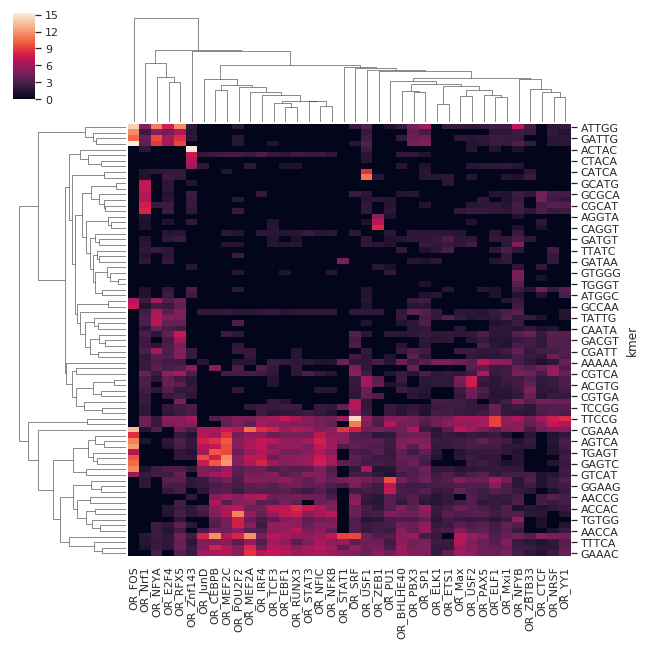

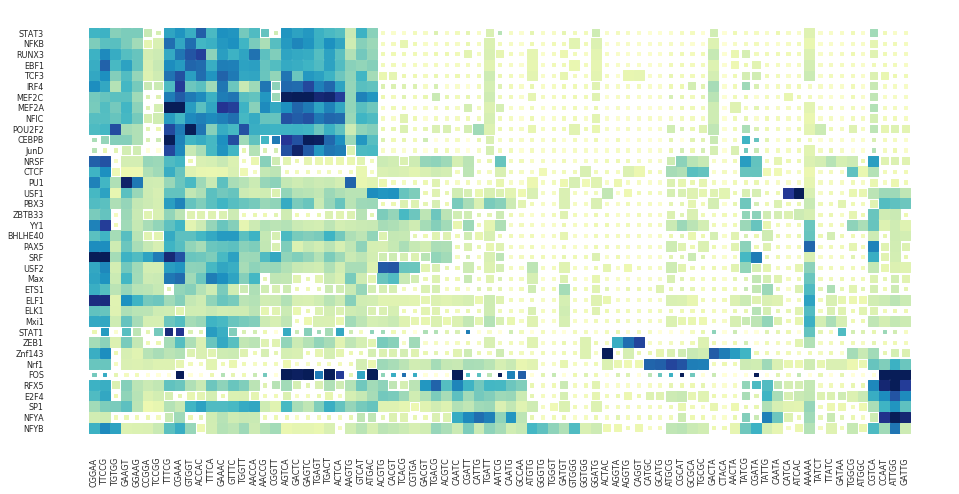

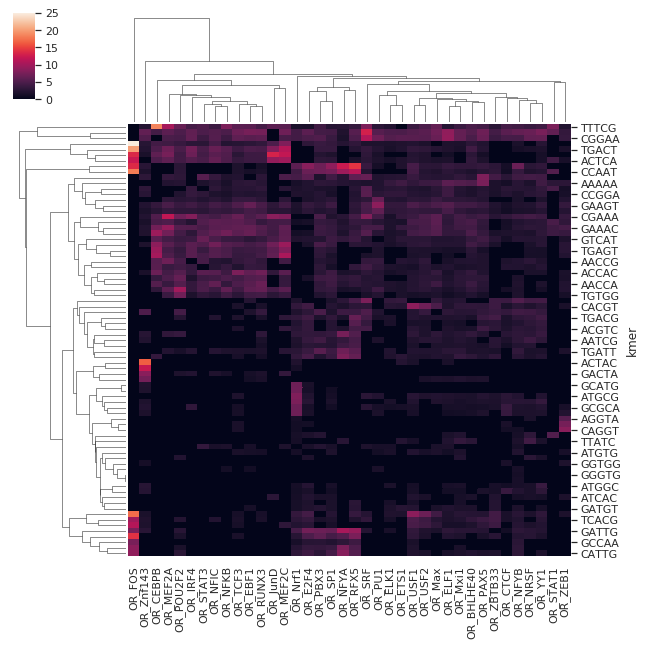

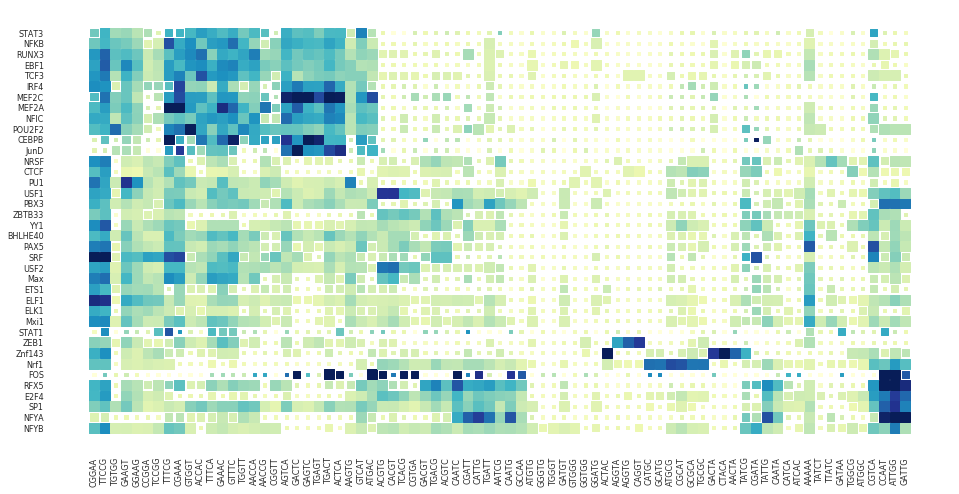

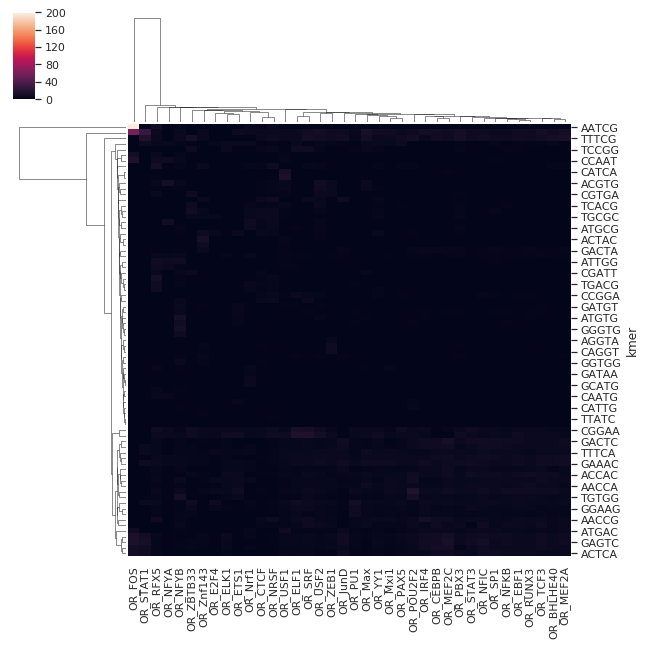

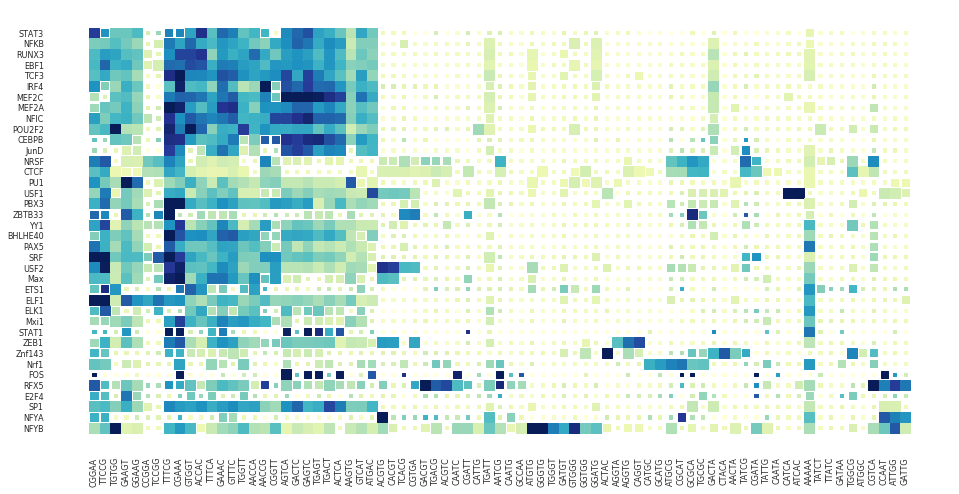

In [150]:
###The heatmap  kmers, all, proximal, distal ###

kmerlist = ylabs # To use pre-clustered order

# Using unified kmer list
df = ORdata.copy()
df.index = df["kmer"]
xlabs, ylabs = heatmap(
    ORmatrix=df[df["kmer"].apply(lambda x: x in kmerlist)][orcols],
    Pmatrix=df[df["kmer"].apply(lambda x: x in kmerlist)][pcols],
    outprefix="allsites%s_unifiedkmers"%GCsuffix,
    x_labels = xlabs, y_labels=ylabs,
)
print(len(ylabs))
#f = open("kmers_ordered_all.txt", "w")
#for item in ylabs: f.write(item+"\n")
#f.close()
#f = open("tfs_ordered_all.txt", "w")
#for item in xlabs: f.write(item+"\n")
#f.close()

dflabels = ["proximal","distal"]
ind = 0
for df in [ORdata_proximal, ORdata_distal]:
    dflabel = dflabels[ind]
    df.index = df["kmer"]
    heatmap(
        ORmatrix=df[df["kmer"].apply(lambda x: x in kmerlist)][orcols],
        Pmatrix=df[df["kmer"].apply(lambda x: x in kmerlist)][pcols],
        outprefix=dflabel+GCsuffix+"_unifiedkmers",
        x_labels = xlabs, y_labels=ylabs,
        pthresh=0.01
    )
    ind += 1

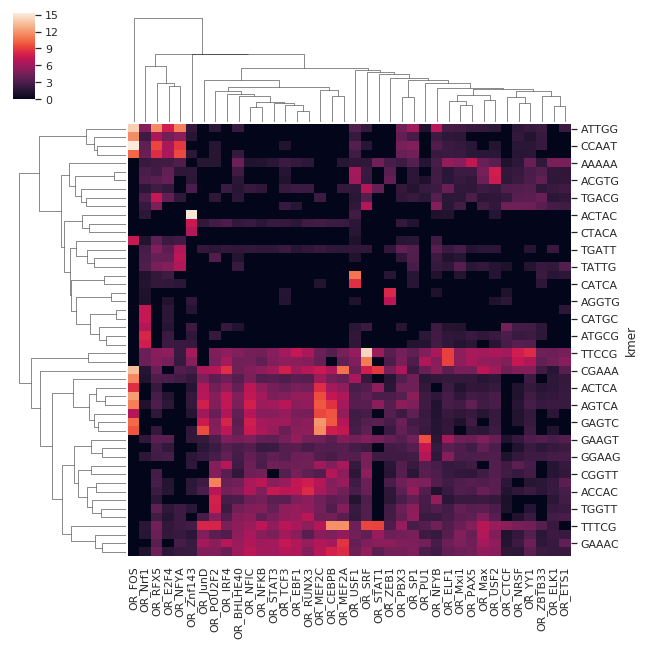

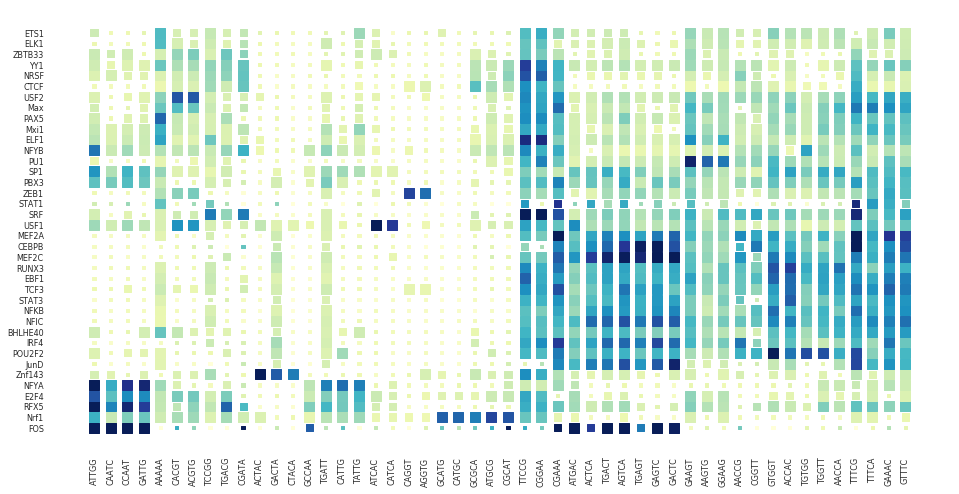

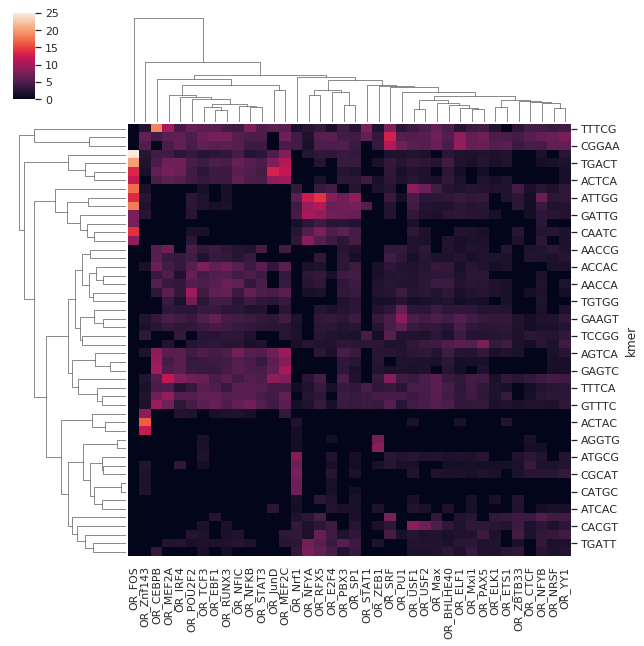

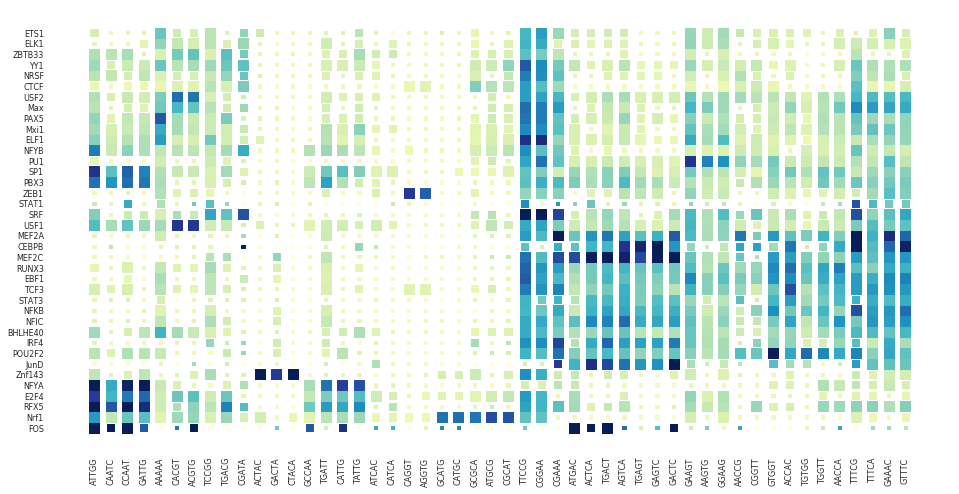

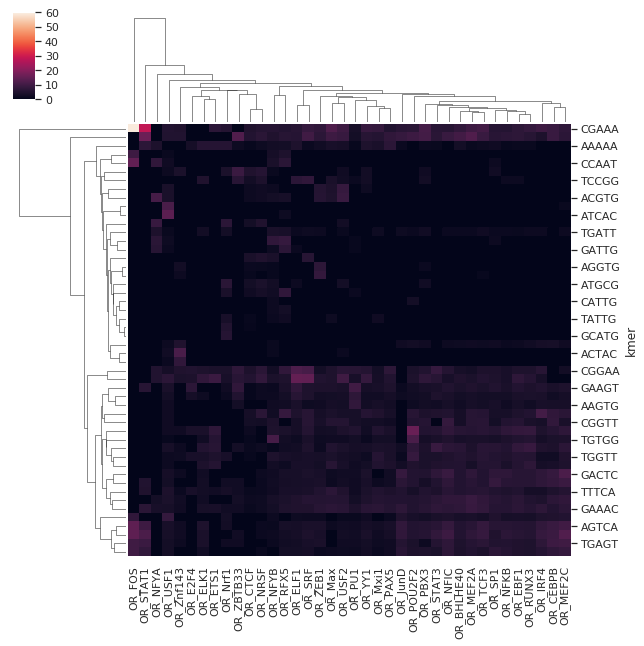

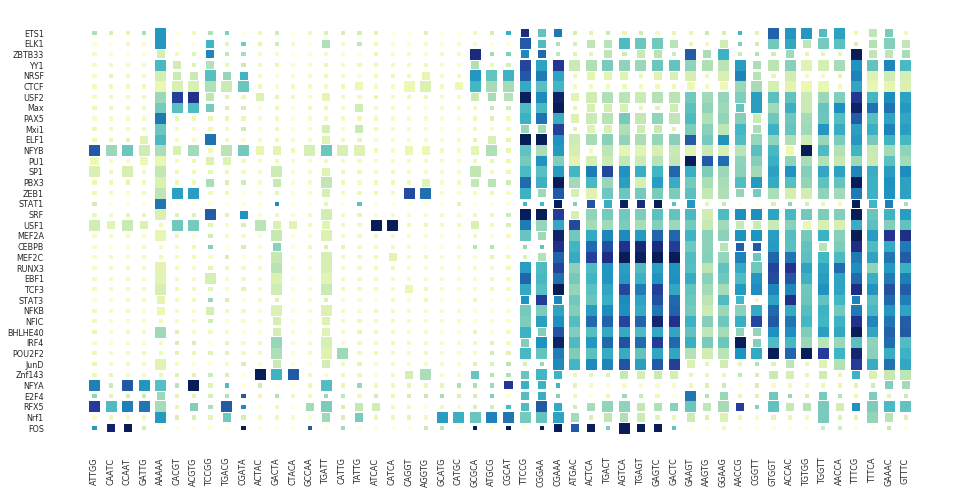

In [151]:
###The heatmap of the new top 50 kmers, all, proximal, distal ###

taketop = 50
df = ORdata.copy()
df["score"] = df.apply(lambda x: GetBestSigOR(x), 1)
df = df.sort_values("score", ascending=False)

xlabs, ylabs = heatmap(
    ORmatrix=df.head(n=taketop)[orcols],
    Pmatrix=df.head(n=taketop)[pcols],
    outprefix="allsites%s"%GCsuffix
)
f = open("kmers_%s.txt"%GCsuffix, "w")
for item in ylabs: f.write(item+"\n")
f.close()

dflabels = ["proximal","distal"]
ind = 0
for df in [ORdata_proximal, ORdata_distal]:
    dflabel = dflabels[ind]
    heatmap(
        ORmatrix=df[df["kmer"].apply(lambda x: x in ylabs)][orcols],
        Pmatrix=df[df["kmer"].apply(lambda x: x in ylabs)][pcols],
        outprefix=dflabel+GCsuffix,
        x_labels = xlabs, y_labels=ylabs,
        pthresh=0.01
    )
    ind += 1

In [152]:
factor = "SP1"

ORdata.index = range(ORdata.shape[0])
ORdata_proximal.index = range(ORdata_proximal.shape[0])
ORdata_distal.index = range(ORdata_distal.shape[0])

fdf = pd.merge(pd.merge(ORdata[["OR_%s"%factor, "pval_%s"%factor, "kmer"]],
                        ORdata_proximal[["OR_%s"%factor, "pval_%s"%factor, "kmer"]], on=["kmer"], suffixes=("_all","_prox")),
         ORdata_distal[["OR_%s"%factor, "pval_%s"%factor, "kmer"]], on=["kmer"])
fdf["OR_%s_dist"%factor] = fdf["OR_%s"%factor]
fdf["pval_%s_dist"%factor] = fdf["pval_%s"%factor]
fdf["maxOR"] = fdf[["OR_%s_all"%factor,"OR_%s_prox"%factor,"OR_%s_dist"%factor]].apply(np.max, 1)

cdf = pd.merge(pd.merge(conf[["ci_upper_%s"%factor, "ci_lower_%s"%factor, "kmer"]], 
                        conf_prox[["ci_upper_%s"%factor, "ci_lower_%s"%factor, "kmer"]], on=["kmer"], suffixes=("_all","_prox")),
         conf_dist[["ci_upper_%s"%factor, "ci_lower_%s"%factor,"kmer"]], on=["kmer"])
cdf["ci_lower_%s_dist"%factor] = cdf["ci_lower_%s"%factor]
cdf["ci_upper_%s_dist"%factor] = cdf["ci_upper_%s"%factor]

pldata = pd.merge(cdf, fdf, on=["kmer"])
pldata["score"] = pldata.apply(lambda x: GetBestSigOR(x, pthresh=0.01), 1)
pldata = pldata.sort_values("score", ascending=False).head(n=20)

pldata["diff"] = pldata.apply(lambda x: (x["OR_%s_prox"%factor]-x["OR_%s_dist"%factor]), 1)
pldata = pldata.sort_values("diff", ascending=False)

for suffix in ["all","prox","dist"]:
    pldata["ci_upper_%s_%s"%(factor,suffix)] = pldata["ci_upper_%s_%s"%(factor, suffix)]-pldata["OR_%s_%s"%(factor, suffix)]
    pldata["ci_lower_%s_%s"%(factor,suffix)] = pldata["OR_%s_%s"%(factor, suffix)]-pldata["ci_lower_%s_%s"%(factor, suffix)]

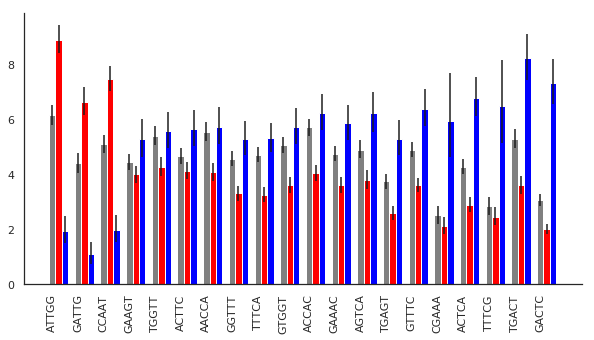

In [153]:

pldata["order"] = range(pldata.shape[0])
pldata = pldata.sort_values("order")

sns.set_style("white")

fig = plt.figure()
fig.set_size_inches((10, 5))
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
w = 0.25
ax.bar(pldata["order"], pldata["OR_%s_all"%factor], color="gray", width=w,
      yerr=[list(pldata["ci_lower_%s_all"%factor]), list(pldata["ci_upper_%s_all"%factor])])
ax.bar([item+w for item in pldata["order"]], pldata["OR_%s_prox"%factor], color="red", width=w,
      yerr=[list(pldata["ci_lower_%s_prox"%factor]), list(pldata["ci_upper_%s_prox"%factor])]);
ax.bar([item+2*w for item in pldata["order"]], pldata["OR_%s_dist"%factor], color="blue", width=w,
      yerr=[list(pldata["ci_lower_%s_dist"%factor]), list(pldata["ci_upper_%s_dist"%factor])]);
ax.grid(False)
ax.set_xticks(range(pldata["kmer"].shape[0]))
ax.set_xticklabels(pldata["kmer"], rotation=90);
fig.savefig("AgentBind-SP1-proxdist-%s.pdf"%GCsuffix);

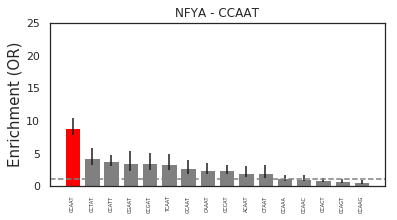

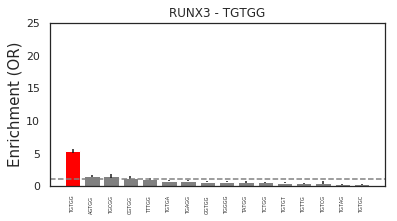

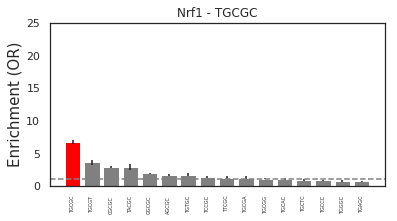

In [154]:
def PlotOffByOne(factor, canon, ORdata):
    nucs = ["A","C","G","T"]
    kmers = [canon]
    for i in range(len(canon)):
        realnuc = canon[i]
        for nuc in nucs:
            if nuc != realnuc:
                newkmer = canon[:i] + nuc + canon[i+1:]
                kmers.append(newkmer)
    df = ORdata[["kmer","OR_%s"%factor]]
    cdf = conf[["kmer","ci_upper_%s"%factor, "ci_lower_%s"%factor]]
    df = pd.merge(df, cdf, on=["kmer"])
    df = df[df["kmer"].apply(lambda x: x in kmers)].sort_values("OR_%s"%factor, ascending=False)

    # Set CIs to be errors rather than ranges
    df["ci_upper_%s"%factor] = df["ci_upper_%s"%factor]-df["OR_%s"%factor]
    df["ci_lower_%s"%factor] = df["OR_%s"%factor]-df["ci_lower_%s"%factor]

    fig = plt.figure()
    fig.set_size_inches((6, 3))
    ax = fig.add_subplot(111)
    ax.bar(range(df.shape[0]), df["OR_%s"%factor],
          color = ["red"]+["gray"]*(df.shape[0]-1),
          yerr=[list(df["ci_lower_%s"%factor]), list(df["ci_upper_%s"%factor])])
    ax.set_ylim(bottom=0, top=25)
    ax.axhline(y=1, linestyle="dashed", color="gray")
    ax.set_xticks(range(df.shape[0]))
    ##Changed the size smaller because the PDF hide a portion of x labels
    ax.set_xticklabels(df["kmer"], rotation=90, size = 5)
    ax.set_title("%s - %s"%(factor, canon))
    ax.set_ylabel("Enrichment (OR)", size=15)
    fig.savefig("AgentBind-OffByOne-%s-%s%s.pdf"%(factor, canon, GCsuffix))
    
df = ORdata
PlotOffByOne("NFYA","CCAAT", df)
PlotOffByOne("RUNX3","TGTGG", df)
PlotOffByOne("Nrf1","TGCGC", df)

In [155]:
factor="NRSF"
print(basepath)
fpath = os.path.join(basepath, "results/c/%s+GM12878/kmer_ranking.txt")

x = pd.read_csv(fpath%factor, sep="\t", usecols=[0,1,2,4,5],
                         names=["kmer","pval_%s"%factor,"OR_%s"%factor,
                               "n_ttl_%s"%factor, "n_pos_%s"%factor])
#x.sort_values("OR_%s"%factor, ascending=False).head(n=20)
x[x["kmer"]=="GATAA"]
#"CAGGT" in max_kmers

/storage/pandaman/project/AgentBind-GM12878-analysis/


,kmer,pval_NRSF,OR_NRSF,n_ttl_NRSF,n_pos_NRSF
130,GATAA,1.606555e-08,2.066648,3670,75
